# Noisy-Clustering

In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import tensorflow as tf
import tensorflow_hub as tfhub
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib

In [2]:
txt_dir = "../datasets/cleaned_datasets/clean_dataset" 

## Reading Data into DataFrame

In [3]:
def read_data(_dir:str) -> pd.DataFrame:
    data = {}
    data["url"] = []
    data["text"] = []
    data["class"] = []
    for root, dirs, files in os.walk(_dir):
        for _dir in dirs: 
            for txt_file in [x for x in os.listdir(os.path.join(root, _dir)) if x.endswith((".txt", ".TXT"))]:
                # Class name = dir name
                class_name = _dir
                #Read File
                file_name = os.path.abspath(os.path.join(root, _dir, txt_file))
                file = open(file_name, "r")
                txt = file.read()
                file.close()
                data["url"].append(file_name)
                data["text"].append(txt)
                data["class"].append(class_name)
    df = pd.DataFrame.from_dict(data)
    del data
    return df

In [4]:
%%time
df = read_data(txt_dir)

CPU times: user 740 ms, sys: 882 ms, total: 1.62 s
Wall time: 2.77 s


In [5]:
df.head()

,url,text,class
0,/Users/Daniel/PycharmProjects/Recommender-Syst...,the goal of feature selection in text classifi...,prediction
1,/Users/Daniel/PycharmProjects/Recommender-Syst...,conclusion a major assumption of regression or...,prediction
2,/Users/Daniel/PycharmProjects/Recommender-Syst...,in category as a supervised machine process is...,prediction
3,/Users/Daniel/PycharmProjects/Recommender-Syst...,the pls regression is used to connect the depe...,prediction
4,/Users/Daniel/PycharmProjects/Recommender-Syst...,pace regression the basic idea of regression a...,prediction


## Get the Embeddings

In [6]:
model_url = "./DAN/1fb57c3ffe1a38479233ee9853ddd7a8ac8a8c47/"

In [7]:
%%time
model = tfhub.Module(model_url)

CPU times: user 1.69 s, sys: 120 ms, total: 1.81 s
Wall time: 1.82 s


In [8]:
sess = tf.InteractiveSession()

In [9]:
sess.run([tf.global_variables_initializer(), tf.tables_initializer()])

[None, None]

In [10]:
%%time
embeddings = sess.run(model(list(df["text"])))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
CPU times: user 11.4 s, sys: 1.46 s, total: 12.9 s
Wall time: 11.8 s


In [11]:
sess.close()

In [12]:
print(df.shape)
print(embeddings.shape)

(10306, 3)
(10306, 512)


In [13]:
embeddings[0].reshape(1,-1).shape

(1, 512)

In [14]:
df["embedding"] = [np.squeeze(x.reshape(1,-1)) for x in embeddings]

In [15]:
df.head()

,url,text,class,embedding
0,/Users/Daniel/PycharmProjects/Recommender-Syst...,the goal of feature selection in text classifi...,prediction,"[0.02091142, -0.042140108, -0.008535606, 0.006..."
1,/Users/Daniel/PycharmProjects/Recommender-Syst...,conclusion a major assumption of regression or...,prediction,"[-0.022017265, -0.040350087, -0.013414536, -0...."
2,/Users/Daniel/PycharmProjects/Recommender-Syst...,in category as a supervised machine process is...,prediction,"[0.0024706149, -0.06767778, -0.006135382, -0.0..."
3,/Users/Daniel/PycharmProjects/Recommender-Syst...,the pls regression is used to connect the depe...,prediction,"[-0.012890103, 0.036593255, -0.0019980855, -0...."
4,/Users/Daniel/PycharmProjects/Recommender-Syst...,pace regression the basic idea of regression a...,prediction,"[0.029195484, -0.0001973573, -0.035709944, -0...."


## Dimensionality Reduction

### 3D PCA

In [16]:
pca = PCA(n_components=3)

In [17]:
embeddings_lst = []

for emb in embeddings: 
    embeddings_lst.append(emb)

In [18]:
matrix = pca.fit_transform(embeddings_lst)

In [19]:
matrix.shape

(10306, 3)

In [20]:
df["x"] = matrix[:,0]
df["y"] = matrix[:,1]
df["z"] = matrix[:,2]

### 2D PCA

In [21]:
pca = PCA(n_components=2)

In [22]:
embeddings_lst = []

for emb in embeddings: 
    embeddings_lst.append(emb)

In [23]:
matrix = pca.fit_transform(embeddings_lst)

In [24]:
df["a"] = matrix[:,0]
df["b"] = matrix[:,1]

In [25]:
df.head()

,url,text,class,embedding,x,y,z,a,b
0,/Users/Daniel/PycharmProjects/Recommender-Syst...,the goal of feature selection in text classifi...,prediction,"[0.02091142, -0.042140108, -0.008535606, 0.006...",-0.060099,0.140094,0.214230,-0.060097,0.140112
1,/Users/Daniel/PycharmProjects/Recommender-Syst...,conclusion a major assumption of regression or...,prediction,"[-0.022017265, -0.040350087, -0.013414536, -0....",0.208037,0.044546,-0.011725,0.208038,0.044543
2,/Users/Daniel/PycharmProjects/Recommender-Syst...,in category as a supervised machine process is...,prediction,"[0.0024706149, -0.06767778, -0.006135382, -0.0...",-0.076284,0.027439,0.402122,-0.076284,0.027444
3,/Users/Daniel/PycharmProjects/Recommender-Syst...,the pls regression is used to connect the depe...,prediction,"[-0.012890103, 0.036593255, -0.0019980855, -0....",0.235620,-0.172957,-0.070757,0.235620,-0.172959
4,/Users/Daniel/PycharmProjects/Recommender-Syst...,pace regression the basic idea of regression a...,prediction,"[0.029195484, -0.0001973573, -0.035709944, -0....",0.270747,0.025769,-0.249923,0.270747,0.025775


## Visualization

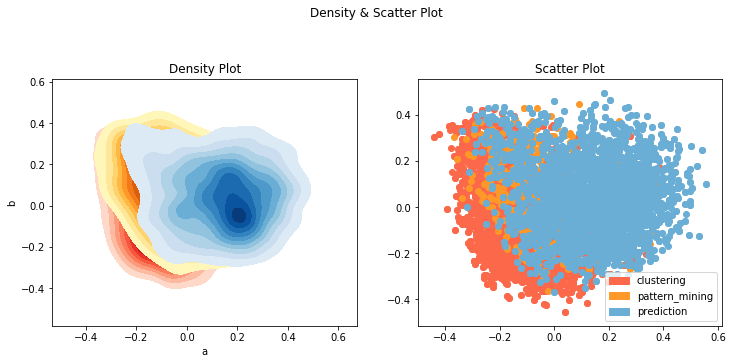

In [45]:
import matplotlib.patches as mpatches


cmaps = cmaps = ["Reds","YlOrBr", "Blues","Greens"]
#colors = ["red", "blue", "purple", "green", "", "grey"]
groups = df.groupby("class")
counter = 0

fig = plt.figure(figsize=(12,10))
fig.suptitle("Density & Scatter Plot")

ax_1 = fig.add_subplot(2,2,1)
ax_2 = fig.add_subplot(2,2,2)

ax_1.set_title("Density Plot")
ax_2.set_title("Scatter Plot")


labels = []
for name, group in groups: 
    # Change that ax = ax_1
    ax = sns.kdeplot(group.a,group.b, shade=True, cmap = cmaps[counter],shade_lowest=False, ax = ax_1)
    color_from_cmap = matplotlib.cm.get_cmap(cmaps[counter])(0.5)
    
    ax_2.scatter(group.a, group.b, color = color_from_cmap)
    labels.append(mpatches.Patch(color=color_from_cmap, label=name))
    counter +=1
legend = plt.legend(handles = labels)


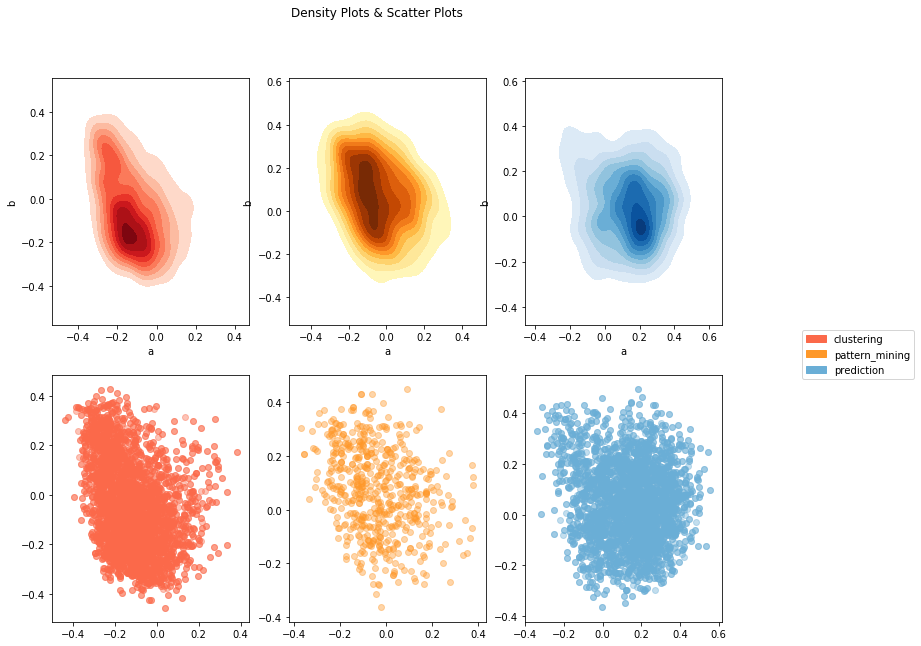

In [46]:
#%matplotlib inline
import matplotlib.patches as mpatches


cmaps = ["Reds","YlOrBr", "Blues","Greens"]
#colors = ["red", "blue", "yellow", "green", "", "grey"]
groups = df.groupby("class")
counter = 0

fig = plt.figure(figsize=(12,10))
fig.suptitle("Density Plots & Scatter Plots")

ax_1 = fig.add_subplot(2,3,1)
ax_2 = fig.add_subplot(2,3,2)
ax_3 = fig.add_subplot(2,3,3)

ax_4 = fig.add_subplot(2,3,4)
ax_5 = fig.add_subplot(2,3,5)
ax_6 = fig.add_subplot(2,3,6)

labels = []
axis = [ax_1, ax_2, ax_3]
axis_scatter = [ax_4, ax_5, ax_6]
for name, group in groups: 
    # Change that ax = ax_1
    ax = sns.kdeplot(group.a,group.b, shade=True, cmap = cmaps[counter],shade_lowest=False, ax = axis[counter])
    color_from_cmap = matplotlib.cm.get_cmap(cmaps[counter])(0.5)
    
    axis_scatter[counter].scatter(group.a, group.b, color = color_from_cmap, alpha = 0.4)
    labels.append(mpatches.Patch(color=color_from_cmap, label=name))
    counter +=1
legend = plt.legend(handles = labels, bbox_to_anchor=(2, 1.2))

<IPython.core.display.Javascript object>


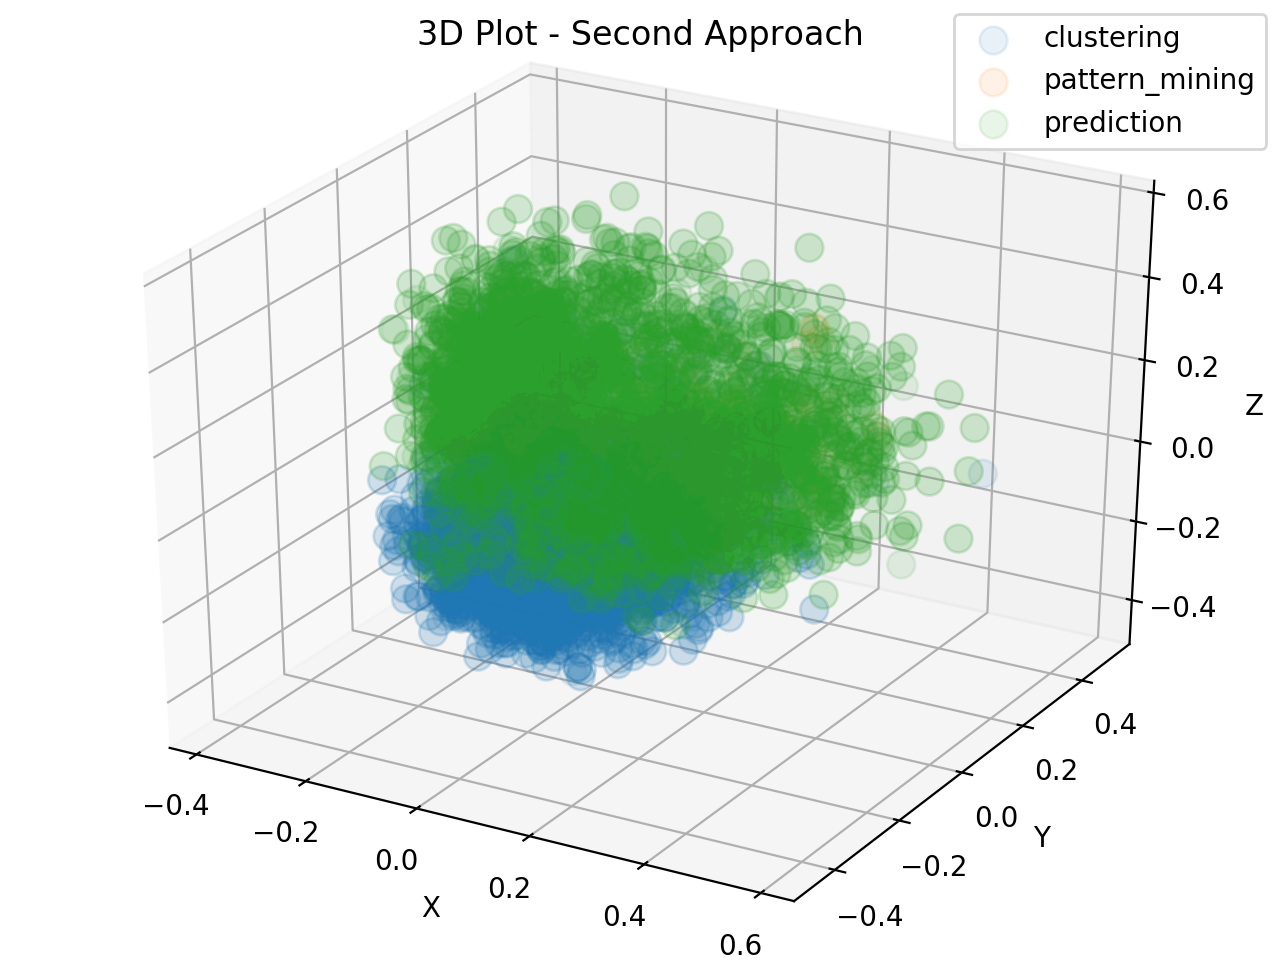

In [47]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
fig.suptitle("3D Plot - Second Approach")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

groups = df.groupby("class")
for name, group in groups:
    
    ax.scatter(group.z, group.y, group.x, s = 100, label=name, alpha = 0.1)
   
    ax.legend()

## Calculate Homogenity/Variance of an Cluster 

In [47]:
from sklearn.metrics.cluster import homogeneity_score
from sklearn.cluster import DBSCAN

In [48]:
clusters = df.groupby("class")

In [50]:
#[x.reshape(1,-1) for x in df["embedding"]]

In [51]:
for _class, data in clusters: 
    embeddings = [x for x in df["embedding"]]
    print("{} variance: {}".format(_class,np.var(np.array(embeddings))))

clustering variance: 0.0019504626980051398
pattern_mining variance: 0.0019504626980051398
prediction variance: 0.0019504626980051398


In [52]:
len(df["embedding"].tolist())

10306

In [ ]:
%%time
model_clustering = DBSCAN(eps = 0.7, n_jobs = 4).fit(df["embedding"].tolist())
model_prediction = DBSCAN(eps = 0.7, n_jobs = 4).fit(df["embedding"].tolist())
model_pattern_mining = DBSCAN(eps = 0.7, n_jobs = 4).fit(df["embedding"].tolist())

In [ ]:
models[model_clustering, model_prediction, model_pattern_mining]

In [ ]:
x = 0
for _class, group in clusters:
    models[x].fit(group["embeddi"])
    x += 1

In [ ]:
cluster_model

In [38]:
model_labels = Counter(cluster_model.labels_)

In [39]:
print(model_labels)

Counter({0: 50601, -1: 379, 1: 8})


In [40]:
outlier_df = df[cluster_model.labels_==-1]

In [41]:
outlier_df

,url,text,class,embedding,x,y,z,a,b
21,/Users/Daniel/PycharmProjects/Recommender-Syst...,with the increase in the carrying capacity of ...,prediction,"[-0.06492987, -0.014353563, 0.009413883, -0.05...",0.093969,-0.021041,0.411160,0.093969,-0.021043
279,/Users/Daniel/PycharmProjects/Recommender-Syst...,synopsis the history of how clouds came to be ...,prediction,"[0.027470805, -0.033396807, -0.018913941, 0.01...",0.149617,0.399923,0.099642,0.149617,0.399923
286,/Users/Daniel/PycharmProjects/Recommender-Syst...,this approach reduces the installation cost of...,prediction,"[0.05274735, 0.0059888097, -0.008290709, -0.02...",-0.130855,-0.053817,0.371286,-0.130855,-0.053818
315,/Users/Daniel/PycharmProjects/Recommender-Syst...,today smartphone devices are owned by a large ...,prediction,"[0.05467753, -0.059222285, -0.042248756, 0.034...",-0.025516,-0.159450,0.146186,-0.025516,-0.159450
751,/Users/Daniel/PycharmProjects/Recommender-Syst...,sentiment classification is widely used for pr...,prediction,"[0.057286397, 0.045865014, -0.00023642596, 0.0...",-0.045568,-0.086393,0.337365,-0.045568,-0.086391
1533,/Users/Daniel/PycharmProjects/Recommender-Syst...,this chapter presents the fundamentals of weed...,prediction,"[0.053654317, -0.061584827, -0.0035621617, 0.0...",0.068876,0.264669,0.062493,0.068876,0.264671
1563,/Users/Daniel/PycharmProjects/Recommender-Syst...,this chapter introduces readers to the concept...,prediction,"[-0.019143775, 0.06330485, -0.015957784, -0.02...",-0.058386,-0.141586,0.207963,-0.058386,-0.141586
1581,/Users/Daniel/PycharmProjects/Recommender-Syst...,new classification system was proposed by tonk...,prediction,"[0.04802414, -0.033430945, -0.0031296352, -0.0...",0.203915,-0.264806,0.045996,0.203915,-0.264805
1604,/Users/Daniel/PycharmProjects/Recommender-Syst...,there are over one million apps on google play...,prediction,"[0.0286811, -0.056983188, -0.009327049, -0.008...",-0.117389,-0.135403,0.150655,-0.117389,-0.135403
1753,/Users/Daniel/PycharmProjects/Recommender-Syst...,assessment of classification techniques on pre...,prediction,"[0.037640903, -0.025213758, -0.03730542, -0.00...",-0.194391,-0.113651,0.169555,-0.194391,-0.113653


In [42]:
pd.set_option('display.max_colwidth', -1)
outlier_df[["text", "class"]]

,text,class
21,with the increase in the carrying capacity of passenger vessels parallel to technological developments over the last years accidents resulting in loss of lives have increased.thus accidents involving passenger vessels have become a major issue of concern in the maritime industry.in this study ship collision contact accidents involving passenger vessels between <unknown> and <unknown> were examined.unlike other studies in the literature this investigation proposes a customized human factors analysis and classification system for passenger vessel accidents to facilitate analysing the human factor in passenger vessel accidents.in addition to the core hfacs structure an additional operational condition level has been defined.the violations framework has been divided into the three sub-categories of rule violations procedure violations and abuse of authority instead of the two broad categories of routine and exceptional violations.abuse of authority is an intentional violation made knowingly and wilfully therefore abuse of authority has been considered separately.furthermore appropriate modifications have been made to the headings under the second level of hfacs-preconditions for unsafe acts for compliance with the maritime industry,prediction
279,synopsis the history of how clouds came to be named and what those names are is reviewed.the typical visual and microstructural attributes of the cloud genera and their most commonly seen species or varieties are accompanied by a short cloud pictorial atlas,prediction
286,this approach reduces the installation cost of monitoring equipment since only a minimum number of sensors is needed and it also reduces the costs for re-calibration or replacement of sensors during the operation.the new approach was developed and tested using measurements taken on two existing rooftop units in montreal canada,prediction
315,today smartphone devices are owned by a large portion of the population and have become a very popular platform for accessing the internet.smartphones provide the user with immediate access to information and services.however they can easily expose the user to many privacy risks.applications that are installed on the device and entities with access to the device internet traffic can reveal private information about the smartphone user and steal sensitive content stored on the device or transmitted by the device over the internet.in this paper we present a method to reveal various demographics and technical computer skills of smartphone users by their internet traffic records using machine learning classification models.we implement and evaluate the method on real life data of smartphone users and show that smartphone users can be classified by their gender smoking habits software programming experience and other characteristics,prediction
751,sentiment classification is widely used for product reviews and in online social media such as forums twitter and blogs.however the problem of classifying the sentiment of user comments on news sites has not been addressed yet.news sites cover a wide range of domains including politics sports technology and entertainment in contrast to other online social sites such as forums and review sites which are specific to a particular domain.a user associated with a news site is likely to post comments on diverse topics or diverse entities .classifying the sentiment of users tied to various entities may help obtain a holistic view of their personality which could be useful in applications such as online advertising content personalization and political campaign planning.in this paper we formulate the problem of entity-specific sentiment classification of comments posted on news articles in yahoo news and propose novel features that are specific to news comments.experimental results show that our models outperform state-of-the-art baselines,prediction
1533,this chapter presents the fundamentals of weed classification based on phylogenetics

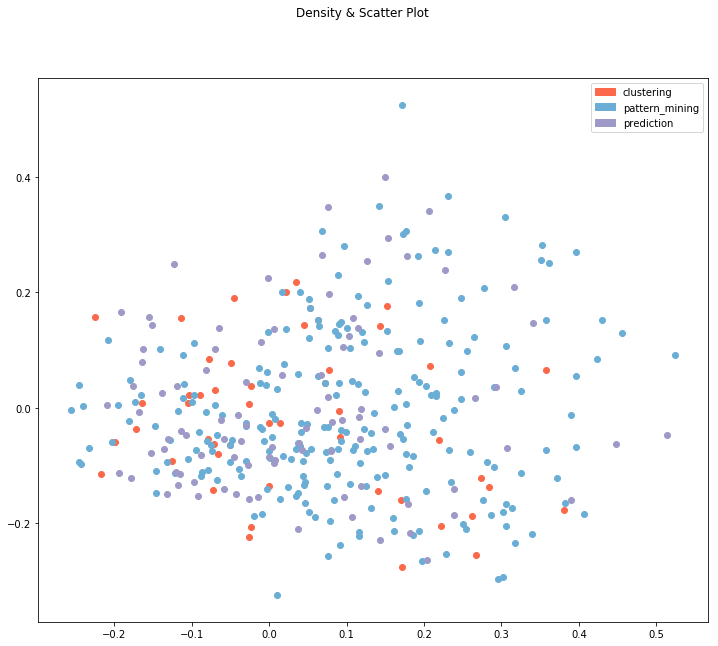

In [43]:
%matplotlib inline
import matplotlib.patches as mpatches


cmaps = ["Reds", "Blues", "Purples","Greens","cool", "Greys","Rainbow"]
colors = ["red", "blue", "purple", "green", "", "grey"]
groups = outlier_df.groupby("class")
counter = 0

fig = plt.figure(figsize = (12,10))
fig.suptitle("Density & Scatter Plot")
ax_2 = fig.add_subplot(1,1,1)

labels = []
for name, group in groups: 
    color_from_cmap = matplotlib.cm.get_cmap(cmaps[counter])(0.5)
    ax_2.scatter(group.a, group.b, color = color_from_cmap)
    labels.append(mpatches.Patch(color=color_from_cmap, label=name))
    counter +=1
legend = plt.legend(handles = labels)

In [44]:
# Macht wenig Sinn, dass auf allen Daten zumachen! Sollte auf jeder Klasse einzeln gemacht werden. 